## Research Question 3: What are the chances of success (IPO, acquired) vs. failure?


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
import plotly.express as px
import pycountry #needed to convert country code into country name
 

pd.set_option('display.max_columns', 500)

In [4]:
# Loading olympic datafiles into DataFrames

startup_df = pd.read_csv('big_startup_secsees_dataset 2.csv')
startup_df = startup_df.loc[startup_df['funding_total_usd'] != '-',:]

In [5]:
# Creating functions needed later

def convert_date(date_str):
    try:
        date = pd.to_datetime(date_str, format='%Y-%m-%d')
        if 1900 <= date.year <= 2050:
            return date
        else:
            # Handle out-of-range years or invalid dates as needed
            return None  # Or any other action (e.g., logging, replacing with NaN)
    except ValueError:
        return None  # Or handle other parsing issues
    
def time_delta_to_days(td):
    return td.days

def time_delta_to_years(td):
    return td.years


def convert_country_code_to_name(country_code):
    try:
        country = pycountry.countries.get(alpha_3=country_code)
        if country:
            return country.name
        else:
            return "Country not found"
    except LookupError:
        return "Lookup error occurred"

In [6]:
startup_df.shape

(53583, 14)

In [7]:
startup_df.nunique(axis=0)

permalink            53583
name                 53409
homepage_url         50119
category_list        23368
funding_total_usd    18895
status                   4
country_code           134
state_code             302
region                1045
city                  4300
funding_rounds          19
founded_at            3523
first_funding_at      4569
last_funding_at       4237
dtype: int64

In [8]:
startup_df.dtypes

permalink            object
name                 object
homepage_url         object
category_list        object
funding_total_usd    object
status               object
country_code         object
state_code           object
region               object
city                 object
funding_rounds        int64
founded_at           object
first_funding_at     object
last_funding_at      object
dtype: object

In [9]:
startup_df.head(5)

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,Media,10000000,operating,IND,16,Mumbai,Mumbai,1,NaN,2015-01-05,2015-01-05
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000,operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878,operating,NaN,NaN,NaN,NaN,1,NaN,2014-01-30,2014-01-30
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000,operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19
5,/organization/01games-technology,01Games Technology,http://www.01games.hk/,Games,41250,operating,HKG,NaN,Hong Kong,Hong Kong,1,NaN,2014-07-01,2014-07-01


In [18]:
# Pre-processing

#Change date columns from string to datetime
startup_df['founded_at']= startup_df['founded_at'].map(convert_date)
startup_df['first_funding_at']= startup_df['first_funding_at'].map(convert_date)
startup_df['last_funding_at'] = startup_df['last_funding_at'].map(convert_date)

#Create year columns
startup_df['founded_year'] = pd.DatetimeIndex(startup_df['founded_at']).year
startup_df['first_funding_year'] = pd.DatetimeIndex(startup_df['first_funding_at']).year
startup_df['last_funding_year'] = pd.DatetimeIndex(startup_df['last_funding_at']).year

#Create month columns
startup_df['founded_month'] = pd.DatetimeIndex(startup_df['founded_at']).month
startup_df['first_funding_month'] = pd.DatetimeIndex(startup_df['first_funding_at']).month
startup_df['last_funding_month'] = pd.DatetimeIndex(startup_df['last_funding_at']).month


#Create duration columns being funding rounds and founding (days)
startup_df['days_to_first_funding'] = (startup_df.first_funding_at - startup_df.founded_at).map(time_delta_to_days)
startup_df['days_between_first_and_recent_funding'] = (startup_df.last_funding_at - startup_df.first_funding_at).map(time_delta_to_days)
startup_df['days_between_founding_and_recent_funding'] = (startup_df.last_funding_at - startup_df.founded_at).map(time_delta_to_days)


#Create duration columns being funding rounds and founding (years)
startup_df['year_to_first_funding'] = (startup_df['days_to_first_funding'] / 365).astype(float)
startup_df['year_between_first_and_recent_funding'] = (startup_df['days_between_first_and_recent_funding'] / 365).astype(float)
startup_df['years_between_founding_and_recent_funding'] = (startup_df['days_between_founding_and_recent_funding'] / 365).astype(float)

#Calculate total funding normalized by number of rounds of funding
startup_df['funding_total_usd']= startup_df['funding_total_usd'].astype(float)
startup_df['total_funding_normalized_by_rounds'] = startup_df['funding_total_usd'] / startup_df['funding_rounds']

#Creating a total funding normalized by days from first to recent funding
startup_df['total_funding_normalized_by_rounds'] = startup_df['funding_total_usd'] / startup_df['days_between_first_and_recent_funding']

#Creating a country column
startup_df['country_name'] = startup_df['country_code'].map(convert_country_code_to_name)

#Converting category_list to string
startup_df['category_list']= startup_df['category_list'].astype(str)


#Capitalizing status names
startup_df['status'] = startup_df['status'].str.capitalize().str.replace('Ipo', 'IPO')


startup_df.head(5)

,permalink,name,homepage_url,category_list,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_year,first_funding_year,last_funding_year,founded_month,first_funding_month,last_funding_month,days_to_first_funding,days_between_first_and_recent_funding,days_between_founding_and_recent_funding,year_to_first_funding,year_between_first_and_recent_funding,years_between_founding_and_recent_funding,total_funding_normalized_by_rounds,country_name
0,/organization/-fame,#fame,http://livfame.com,Media,10000000.0,Operating,IND,16,Mumbai,Mumbai,1,NaT,2015-01-05,2015-01-05,NaN,2015.0,2015.0,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.000000,NaN,inf,India
1,/organization/-qounter,:Qounter,http://www.qounter.com,Application Platforms|Real Time|Social Network...,700000.0,Operating,USA,DE,DE - Other,Delaware City,2,2014-09-04,2014-03-01,2014-10-14,2014.0,2014.0,2014.0,9.0,3.0,10.0,-187.0,227.0,40.0,-0.512329,0.621918,0.109589,3083.700441,United States
2,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,Apps|Games|Mobile,3406878.0,Operating,NaN,NaN,NaN,NaN,1,NaT,2014-01-30,2014-01-30,NaN,2014.0,2014.0,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.000000,NaN,inf,Lookup error occurred
3,/organization/0-6-com,0-6.com,http://www.0-6.com,Curated Web,2000000.0,Operating,CHN,22,Beijing,Beijing,1,2007-01-01,2008-03-19,2008-03-19,2007.0,2008.0,2008.0,1.0,3.0,3.0,443.0,0.0,443.0,1.213699,0.000000,1.213699,inf,China
5,/organization/01games-technology,01Games Technology,http://www.01games.hk/,Games,41250.0,Operating,HKG,NaN,Hong Kong,Hong Kong,1,NaT,2014-07-01,2014-07-01,NaN,2014.0,2014.0,NaN,7.0,7.0,NaN,0.0,NaN,NaN,0.000000,NaN,inf,Hong Kong


In [19]:
startup_df.shape #doubled the number of columns via feature engineering

(53583, 28)

In [20]:
# Creating a new dataframe that splits each industry per cell in category list into an individual row.

startup_df_categories = startup_df.copy()
startup_df_categories['category_list'] = startup_df_categories['category_list'].apply(lambda x: x.split('|'))

# i keeps tracks of index
index=0
# save [index, genre] in a nested list
list_ = []
for item in startup_df_categories['category_list']:
    list_.extend(map(lambda x: [index, x], item))
    index += 1
category_list = pd.DataFrame(list_, columns = ['index', 'category_list'])
category_list.head(15) 
#df_genre.genres

startup_df_categories = pd.merge(startup_df_categories.drop('category_list', axis = 1), category_list, how = 'right', left_index = True, right_on = 'index')
print(startup_df_categories.shape)
startup_df_categories.head()



(129282, 29)


,permalink,name,homepage_url,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,first_funding_at,last_funding_at,founded_year,first_funding_year,last_funding_year,founded_month,first_funding_month,last_funding_month,days_to_first_funding,days_between_first_and_recent_funding,days_between_founding_and_recent_funding,year_to_first_funding,year_between_first_and_recent_funding,years_between_founding_and_recent_funding,total_funding_normalized_by_rounds,country_name,index,category_list
0,/organization/-fame,#fame,http://livfame.com,10000000.0,Operating,IND,16,Mumbai,Mumbai,1.0,NaT,2015-01-05,2015-01-05,NaN,2015.0,2015.0,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.000000,NaN,inf,India,0,Media
1,/organization/-qounter,:Qounter,http://www.qounter.com,700000.0,Operating,USA,DE,DE - Other,Delaware City,2.0,2014-09-04,2014-03-01,2014-10-14,2014.0,2014.0,2014.0,9.0,3.0,10.0,-187.0,227.0,40.0,-0.512329,0.621918,0.109589,3083.700441,United States,1,Application Platforms
2,/organization/-qounter,:Qounter,http://www.qounter.com,700000.0,Operating,USA,DE,DE - Other,Delaware City,2.0,2014-09-04,2014-03-01,2014-10-14,2014.0,2014.0,2014.0,9.0,3.0,10.0,-187.0,227.0,40.0,-0.512329,0.621918,0.109589,3083.700441,United States,1,Real Time
3,/organization/-qounter,:Qounter,http://www.qounter.com,700000.0,Operating,USA,DE,DE - Other,Delaware City,2.0,2014-09-04,2014-03-01,2014-10-14,2014.0,2014.0,2014.0,9.0,3.0,10.0,-187.0,227.0,40.0,-0.512329,0.621918,0.109589,3083.700441,United States,1,Social Network Media
4,/organization/-the-one-of-them-inc-,"(THE) ONE of THEM,Inc.",http://oneofthem.jp,3406878.0,Operating,NaN,NaN,NaN,NaN,1.0,NaT,2014-01-30,2014-01-30,NaN,2014.0,2014.0,NaN,1.0,1.0,NaN,0.0,NaN,NaN,0.000000,NaN,inf,Lookup error occurred,2,Apps


Text(0.5, 1.0, 'Frequency of each Status within Startups')

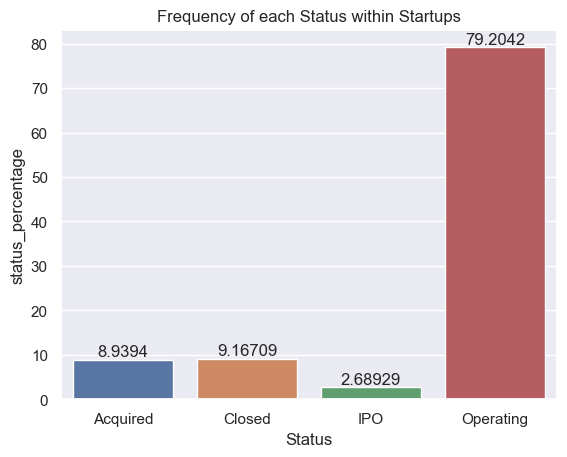

In [21]:
# Frequency of each status for all companies
sns.set_theme(style="darkgrid")


status_group = startup_df.groupby('status')[['permalink']].count().reset_index().assign(total = 53583)
status_group = status_group.assign(status_percentage = (status_group['permalink'] / status_group['total']) * 100)
status_group

ax = sns.barplot(data = status_group, x = 'status',  y = 'status_percentage')
for i in ax.containers:
    ax.bar_label(i,)

    
plt.xlabel("Status")
#Frequency plt.ylabel("Frequency")
plt.title("Frequency of each Status within Startups") 


/Users/bryceferraro/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/bryceferraro/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


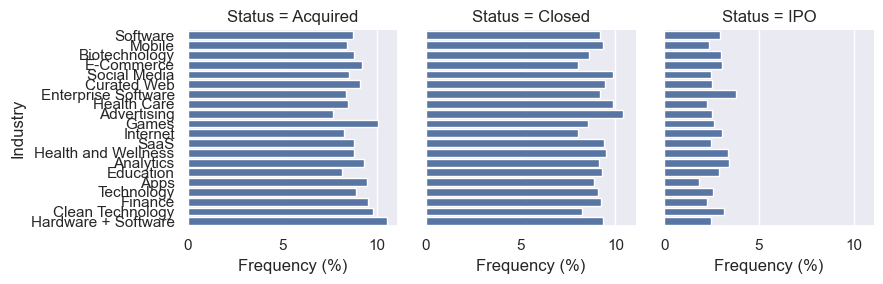

In [24]:
#Frequency of each Status for Top 20 Industries with the Greatest Number of Startups

sns.set_theme(style="darkgrid")

startup_df_categories_pivot = startup_df_categories.loc[:,['permalink','status','category_list']]\
    .groupby(['category_list', 'status']).count().reset_index()\
    .pivot_table(fill_value = 0, index = 'category_list',columns = 'status', values = 'permalink')\
    


startup_df_categories_pivot['total'] = startup_df_categories_pivot['Acquired'] + startup_df_categories_pivot['Closed'] + startup_df_categories_pivot['IPO'] + startup_df_categories_pivot['Operating']

startup_df_categories_pivot['Acquired_frequency'] = (startup_df_categories_pivot['Acquired'] / startup_df_categories_pivot['total']) * 100
startup_df_categories_pivot['Closed_frequency'] = (startup_df_categories_pivot['Closed'] / startup_df_categories_pivot['total']) * 100
startup_df_categories_pivot['IPO_frequency'] = (startup_df_categories_pivot['IPO'] / startup_df_categories_pivot['total']) * 100
startup_df_categories_pivot['Operating_frequency'] = (startup_df_categories_pivot['Operating'] / startup_df_categories_pivot['total']) * 100

top_20_startup_categories = startup_df_categories_pivot.sort_values(by = 'total', ascending = False).head(20).reset_index()

top_20_startup_categories_stacked = top_20_startup_categories.melt(id_vars = 'category_list', value_vars = ['Acquired_frequency','Closed_frequency','IPO_frequency','Operating_frequency'])

top_20_startup_categories_stacked_subset = top_20_startup_categories_stacked.loc[top_20_startup_categories_stacked['status'] != 'Operating_frequency',:].rename(columns = {'category_list': 'Industry', 'status': 'Status', 'value': 'Frequency (%)'})
top_20_startup_categories_stacked_subset['Status']= top_20_startup_categories_stacked_subset['Status'].str.replace('_frequency','')


g = sns.FacetGrid(top_20_startup_categories_stacked_subset, col="Status",palette="Set3")
g.map(sns.barplot,'Frequency (%)','Industry')

# plt.xlabel("Year")
# plt.ylabel("Number of Startup Industries")
# plt.title("Number of Startup Industries over Time") 


/Users/bryceferraro/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/Users/bryceferraro/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


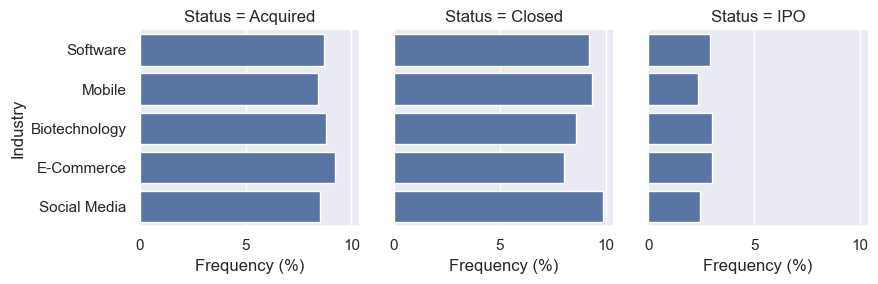

In [25]:
#Frequency of each Status for Top 5 Industries with the Greatest Number of Startups

top_5_startup_categories = startup_df_categories_pivot.sort_values(by = 'total', ascending = False).head(5).reset_index()

top_5_startup_categories_stacked = top_5_startup_categories.melt(id_vars = 'category_list', value_vars = ['Acquired_frequency','Closed_frequency','IPO_frequency','Operating_frequency'])

top_5_startup_categories_stacked_subset = top_5_startup_categories_stacked.loc[top_5_startup_categories_stacked['status'] != 'Operating_frequency',:].rename(columns = {'category_list': 'Industry', 'status': 'Status', 'value': 'Frequency (%)'})
top_5_startup_categories_stacked_subset['Status']= top_5_startup_categories_stacked_subset['Status'].str.replace('_frequency','')


g = sns.FacetGrid(top_5_startup_categories_stacked_subset, col="Status",palette="Set3")
g.map(sns.barplot,'Frequency (%)','Industry')


Text(0.5, 1.0, 'Relationship between Rounds of Funding vs. Startup Status')

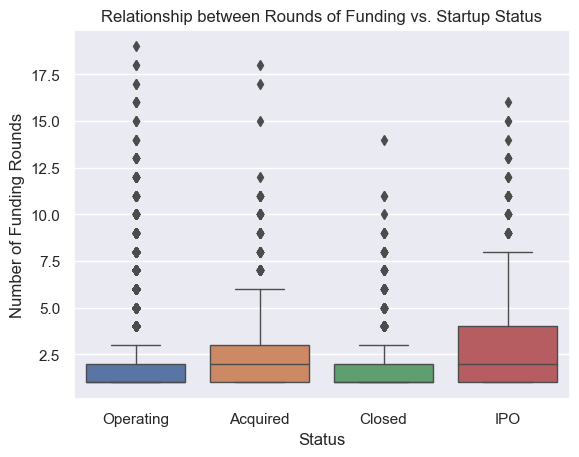

In [27]:
#Relationship between Rounds of Funding vs. Startup Status

sns.set_theme(style="darkgrid")

sns.boxplot(x = 'status', y = 'funding_rounds', 
                data = startup_df,
                linewidth=1)

plt.xlabel("Status")
plt.ylabel("Number of Funding Rounds")
plt.title("Relationship between Rounds of Funding vs. Startup Status") 


Text(0.5, 1.0, 'Relationship between Total Funding vs. Startup Status')

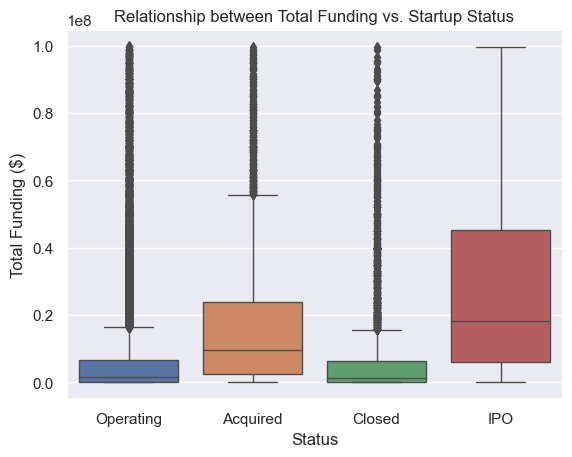

In [29]:
#Relationship between Total Funding Raised vs. Startup Status

sns.set_theme(style="darkgrid")

sns.boxplot(x = 'status', y = 'funding_total_usd', 
                data = startup_df.loc[startup_df['funding_total_usd'] < 100000000,],
                linewidth=1)

plt.xlabel("Status")
plt.ylabel("Total Funding ($)")
plt.title("Relationship between Total Funding vs. Startup Status") 
